### this script for ploting later

In [1]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### Building Value Class

In [70]:
class Value:
  def __init__(self, data,children = [],op = None,label = ""):
    self.data = data
    self._prev = set(children)
    self._op = op
    self.label = label
    self.grad = 0
    self._backward = lambda:None # not to have error if it was just calling None


  def __add__(self, other):

    other  = other if isinstance(other,Value) else Value(other)
    out =  Value(self.data+other.data, [self,other], "+")

    def _backward():
        self.grad += 1 * out.grad
        other.grad +=  1 * out.grad


    out._backward = _backward

    return out


  def __mul__(self,other):
    other  = other if isinstance(other,Value) else Value(other)
    out =  Value(self.data*other.data, [self,other], "*")

    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self,other):
    assert isinstance(other,(int,float)) # only int float


    out = Value(self.data**other, [self,], f'**{other}')
    def _backward():
        self.grad = other * self.data**(other-1) * out.grad # x**z  = zx**z-1
    out._backward = _backward
    return out

  def __truediv__(self, other):
    other.data =  other.data**-1
    result =  self * other
    return result



  def __sub__(self,other):
    return self+ (-other)
  def __neg__(self):
    self.data = -self.data

  def __repr__(self) :
    return str(self.data)
  def __str__(self):
    return str(self.data)


  def backward_all(self):
     li_node = self._topo_sort(self)
     li_node.reverse()
     self.grad = 1
     print(li_node)
     for node in li_node:
       if node.backward:
        node._backward()



  def _topo_sort(self,node, li = [],seen={}):
    for child in node._prev:
         self._topo_sort(child, li)
    if not seen.get(node.data):
      li.append(node)
      seen[node.data] = True


    return li

  def backward(self):

    # topo = []
    # seen = set()
    # def topo_sort(node):
    #   if node not in seen:
    #     seen.add(node)
    #     for child in node._prev:
    #       topo_sort(child)
    #     topo.append(node)


    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # topo_sort(self)
    print(topo)
    topo.reverse()
    self.grad = 1
    print(topo)
    for node in topo:
      node._backward()




In [16]:
a = Value(3)
b = Value(4)
c = a*b
d = c**2

In [5]:
c.grad = 1
print(c.backward)

<function Value.__mul__.<locals>._backward at 0x78471d0605e0>


In [57]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [42]:
L.backward_all()

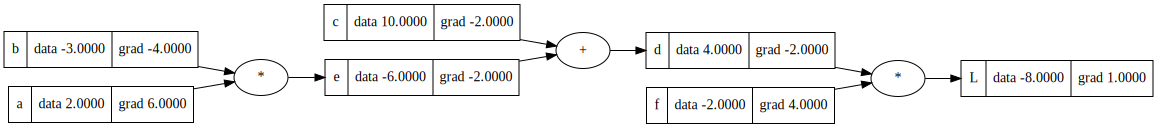

In [43]:
draw_dot(L)

Example 2

In [71]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'


In [72]:
n.backward()

[2.0, -3.0, -6.0, 1.0, 0.0, 0.0, -6.0, 6.881373587019543, 0.8813735870195432]
[0.8813735870195432, 6.881373587019543, -6.0, 0.0, 0.0, 1.0, -6.0, -3.0, 2.0]


In [73]:
n.backward_all()

[0.8813735870195432, 6.881373587019543, 0.0, 1.0, -6.0, -3.0, 2.0]


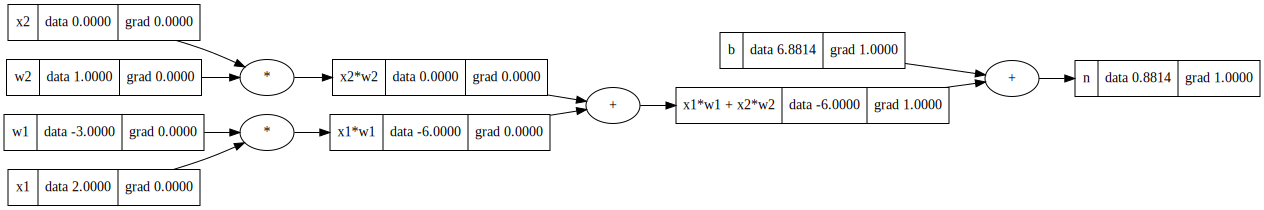

In [48]:
draw_dot(n)

In [10]:
L.grad =1
L.backward()
d.backward()
e.backward()


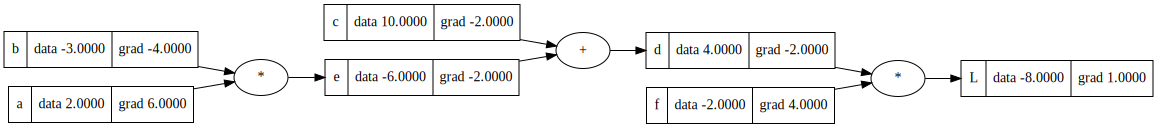

In [11]:
draw_dot(L)

In [45]:
d = Value(3)
e = c/d
f = e*a
g = f-c

h = Value(2)
i = g**h

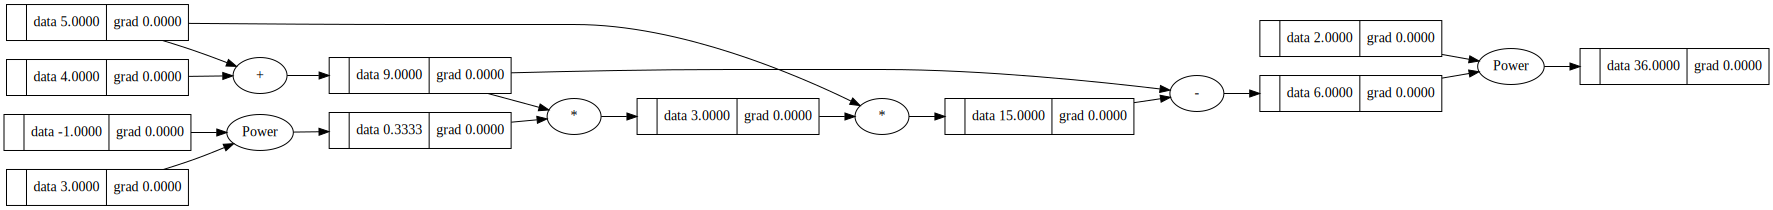

In [46]:
draw_dot(i)

In [141]:
c = lambda:None

In [144]:
def add(n1,n2):
  return n1+n2
c = add

In [145]:
c(3,4)

7

In [150]:
c = add

In [148]:
c(2,3)

5